In [1]:
from train_dualencoder_calgary import create_data_loaders, build_dautomap  
from pathlib import Path
from skimage import measure
from data.transforms import ifft2,fft2, complex_abs
from tqdm import tqdm
import h5py
import numpy as np
from matplotlib import pyplot as plt
from collections import namedtuple
from data import transforms
import torch
import pathlib
from skimage.measure import compare_psnr, compare_ssim

In [2]:
args = {'center_fractions':[0.08],'acceleration_factor':['4x'],'challenge':'singlecoil',
       'train_path':Path('/media/student1/RemovableVolume/calgary/Train'),
        'exp_path':Path('/media/student1/NewVolume/MR_Reconstruction/experiments/calgary/acc_4x/dualencoder_cardiac'),
        'validation_path':Path('/media/student1/RemovableVolume/calgary/Val'),
        'dataset_type':'calgary',
       'resolution':256,
       'sample_rate':1.0,
       'batch_size':10,
        'device':'cuda',
        'data_parallel':False,
        'num_chans':32,
        'num_pools':4,
        'drop_prob':0,
         'sample':0.1
       }
# d_named = namedtuple("Employee", d.keys())(*d.values())
argsobj = namedtuple('args',args.keys())(*args.values())

In [3]:
train_loader, dev_loader,_= create_data_loaders(argsobj)

In [4]:
len(train_loader.dataset)

260

In [5]:
for img,ksp, tgt , _,_ in (dev_loader):
    print(img.shape,ksp.shape,tgt.shape)
    break

torch.Size([10, 256, 256]) torch.Size([10, 256, 256, 2]) torch.Size([10, 256, 256])


In [6]:
img = img.unsqueeze(1)#.to(argsobj.device)
# ksp = ksp.to(argsobj.device)
# ksp = ksp.permute(0,3,1,2)
tgt = tgt.unsqueeze(1)#.to(argsobj.device)

img = img.float()
ksp = ksp.float()
tgt = tgt.float()

In [7]:
ksp.shape , img.shape , tgt.shape

(torch.Size([10, 256, 256, 2]),
 torch.Size([10, 1, 256, 256]),
 torch.Size([10, 1, 256, 256]))

In [8]:
from matplotlib import pyplot as plt
import numpy as np

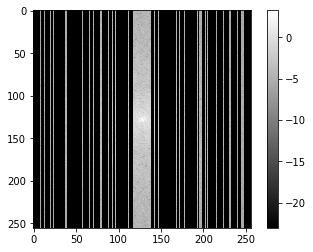

In [9]:
index = 3
import torch
plt.imshow(torch.log(torch.sqrt( ksp[index,:,:,0]**2 + ksp[index,:,:,1]**2) + 1e-10),cmap='gray')
plt.colorbar()

In [10]:
#### ksp_img = ifft2(ksp)
# ksp_img_abs = complex_abs(ksp_img)
# plt.imshow(ksp_img_abs[index,:,:],cmap='gray')
# plt.colorbar()

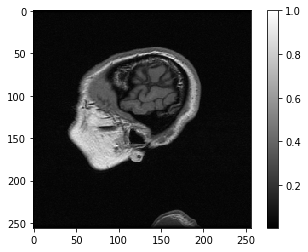

In [11]:
index=6
plt.imshow(tgt[index,0,:,:],cmap='gray')
plt.colorbar()

In [12]:
img_norm = img
img_norm[index] = img[index]/img[index].max()

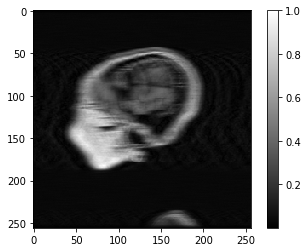

In [13]:
plt.imshow(img[index,0,:,:],cmap='gray')
plt.colorbar()


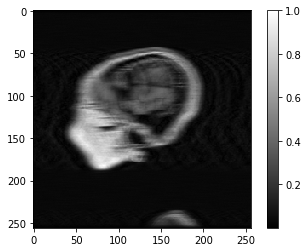

In [14]:
plt.imshow(img_norm[index,0,:,:],cmap='gray')
plt.colorbar()


In [15]:
model = build_dautomap(argsobj)
model

dAUTOMAP(
  (domain_transform): GeneralisedIFT2Layer(
    (idft1): Conv2d(2, 512, kernel_size=(256, 1), stride=(1, 1), bias=False)
    (idft2): Conv2d(2, 512, kernel_size=(256, 1), stride=(1, 1), bias=False)
  )
  (refinement_block): Sequential(
    (0): Conv2d(2, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace)
    (4): ConvTranspose2d(64, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
)

In [ ]:
dt_model = model.domain_transform
dt_model


In [ ]:
dt_op = dt_model(ksp.permute(0,3,1,2).cuda())
dt_op.shape

In [ ]:
plt.imshow(torch.sqrt(dt_op[index,0,:,:]**2 + dt_op[index,1,:,:]**2).detach().cpu(),cmap='gray')
plt.colorbar()

# dataloader check!

In [ ]:
import h5py
fname = '/media/student1/NewVolume/MR_Reconstruction/datasets/fastmri_singlecoil/Train/file1002569.h5'
with h5py.File(fname,'r') as data:
    kspace_rect_cplx = data['kspace'][10]
kspace_rect_cplx.shape , kspace_rect_cplx.dtype

In [ ]:
import numpy as np
kspace_rect_abs = np.abs(kspace_rect_cplx)
plt.imshow(np.log(kspace_rect_abs+1e-10),cmap='gray')

In [ ]:
# kspace_rect = transforms.to_tensor(kspace_rect_cplx)
image_rect  = np.fft.fftshift(np.fft.ifft2(kspace_rect_cplx))

image_rect_abs = np.abs(image_rect)
print(image_rect_abs.shape , image_rect_abs.dtype)
plt.imshow(image_rect_abs,cmap='gray')
plt.colorbar()

In [ ]:
def center_crop(data,shape):
    assert 0 < shape[0] <= data.shape[-2]
    assert 0 < shape[1] <= data.shape[-1]
    w_from = (data.shape[-2] - shape[0]) // 2
    h_from = (data.shape[-1] - shape[1]) // 2
    
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[..., w_from:w_to, h_from:h_to]

In [ ]:
image_sq_abs = center_crop(image_rect_abs,(320,320))
print(image_sq_abs.shape ,  image_sq_abs.dtype)
plt.imshow(image_sq_abs,cmap='gray')
plt.colorbar()

In [ ]:
kspace_sq = np.fft.fftshift(np.fft.fft2(image_sq_abs, axes=(-2, -1))) *1000
kspace_sq.shape , kspace_sq.dtype
plt.imshow(np.log(np.abs(kspace_sq)+1e-10),cmap='gray')
plt.colorbar()

In [ ]:
kspace_tensor = transforms.to_tensor(kspace_sq)
kspace_tensor.shape  , kspace_tensor.dtype

In [ ]:
from common.subsample import MaskFunc
mask_func = MaskFunc(argsobj.center_fractions, argsobj.accelerations)

seed =  tuple(map(ord, fname))
masked_kspace_square, mask = transforms.apply_mask(kspace_tensor.float(), mask_func, seed)
masked_kspace_square.shape

In [ ]:
masked_kspace_square_cplx = masked_kspace_square[:,:,0].numpy() + 1j*masked_kspace_square[:,:,1].numpy()
masked_kspace_square_cplx.shape , masked_kspace_square_cplx.dtype

In [ ]:
plt.imshow(np.log(np.abs(masked_kspace_square_cplx)+1e-10),cmap='gray')
plt.colorbar()

In [ ]:
us_img  = (np.fft.ifft2(masked_kspace_square_cplx)) *10

us_img_abs = np.abs(us_img)
print(us_img_abs.shape , us_img_abs.dtype)
plt.imshow(us_img_abs,cmap='gray')
plt.colorbar()

In [ ]:
# checking......

kspace_sq = np.fft.fftshift(np.fft.fft2(us_img_abs, axes=(-2, -1)))
kspace_sq.shape , kspace_sq.dtype
plt.imshow(np.log(np.abs(kspace_sq)+1e-10),cmap='gray')
plt.colorbar()

In [ ]:
us_img_abs, mean, std = transforms.normalize_instance(us_img_abs, eps=1e-11)
print(us_img_abs.shape , us_img_abs.dtype)
plt.imshow(us_img_abs,cmap='gray')
plt.colorbar()
# us_img = us_img.clamp(-6, 6)

In [ ]:
# fs_img_abs, mean, std = transforms.normalize_instance(image_sq_abs, eps=1e-11)
fs_img_abs , _,_ = transforms.normalize_instance(image_sq_abs ,eps=1e-11)
print(fs_img_abs.shape , us_img_abs.dtype)
plt.imshow(fs_img_abs,cmap='gray')
plt.colorbar()

In [ ]:
us_img_abs, mean, std = transforms.normalize(us_img_abs, eps=1e-11)
print(us_img_abs.shape , us_img_abs.dtype)
plt.imshow(us_img_abs,cmap='gray')
plt.colorbar()

In [ ]:
kspace_sq = np.fft.fftshift(np.fft.fft2(image_sq_abs, axes=(-2, -1)))
kspace_sq.shape , kspace_sq.dtype

# cardiac dataset check!

In [ ]:
root = '/media/student1/NewVolume/MR_Reconstruction/datasets/cardiac/acc_2x/train'
files = list(pathlib.Path(root).iterdir())
fname = str(files[0])

In [ ]:
examples=[]

with h5py.File(fname,'r') as hf:
                fsvol = hf['volfs']
                num_slices = fsvol.shape[2]
                examples += [(fname, slice) for slice in range(num_slices)]

In [ ]:
fname , slice = examples[0]
fname,slice

In [ ]:
with h5py.File(fname, 'r') as data:

            input_img  = data['img_volus_2x'][:,:,slice]
            input_kspace  = data['kspace_volus_2x'][:,:,slice]
#             input_kspace = npComplexToTorch(input_kspace)
    
            target = data['volfs'][:,:,slice]


In [ ]:
plt.imshow(input_img,cmap='gray')
plt.colorbar()

In [ ]:
plt.imshow(np.log(np.abs(input_kspace) + 1e-10),cmap='gray')
plt.colorbar()

In [ ]:
print(target.shape)
plt.imshow(target,cmap='gray')
plt.colorbar()

In [ ]:
kspace =np.fft.fftshift(np.fft.fft2(target))
plt.imshow(np.log(np.abs(kspace)+1e-8))
plt.colorbar()

In [ ]:
img = (np.fft.ifft2(kspace))
plt.imshow(np.abs(img),cmap='gray')
plt.colorbar()

In [ ]:
kspace = transforms.to_tensor(kspace)
# kspace = kspace.unsqueeze(0)
kspace.shape

In [ ]:
# dt_op = dt_model(kspace.permute(0,3,1,2).float().cuda())
# dt_op = dt_op.detach().cpu()

In [ ]:
# plt.imshow(torch.sqrt(dt_op[0,0,:,:]**2 + dt_op[0,1,:,:]**2),cmap='gray')
# plt.colorbar()

In [ ]:
from common.subsample import MaskFunc
mask_func = MaskFunc(argsobj.center_fractions, argsobj.accelerations)

seed =  tuple(map(ord, fname))
masked_kspace_square, mask = transforms.apply_mask(kspace.float(), mask_func, seed)
masked_kspace_square.shape

In [ ]:
import torch
plt.imshow(torch.log(torch.sqrt( masked_kspace_square[:,:,0]**2 + masked_kspace_square[:,:,1]**2) + 1e-10),cmap='gray')
plt.colorbar()
print(masked_kspace_square.shape)

In [ ]:
masked_kspace_square2 = np.pad(masked_kspace_square,((5,5),(5,5),(0,0)),'constant',constant_values=(0,0))
masked_kspace_square2.shape

In [ ]:
masked_kspace_np = masked_kspace_square2[:,:,0] + 1j*masked_kspace_square2[:,:,1]
masked_kspace_np.shape , masked_kspace_np.dtype

In [ ]:
img = np.fft.ifft2(masked_kspace_np)
print(img.shape)
plt.imshow(np.abs(img),cmap='gray')
plt.colorbar()

# model loading

In [ ]:
from models.models import UnetModel

In [ ]:
def load_model(checkpoint_file):
    
    checkpoint = torch.load(checkpoint_file)
    args = checkpoint['args']
    model = UnetModel(
        in_chans=1,
        out_chans=1,
        chans=args.num_chans,
        num_pool_layers=args.num_pools,
        drop_prob=args.drop_prob
    ).to(args.device)
    
    
    

    model.load_state_dict(checkpoint['model'])
    return model

In [ ]:
checkpoint_file = '/media/student1/NewVolume/MR_Reconstruction/experiments/dualencoder_cardiac/cardiac/acc_4x/best_model.pt'


In [ ]:
model = load_model(checkpoint_file)

In [ ]:
model

# reconstruction...making

In [ ]:
f_recons_dauto ='/media/student1/NewVolume/MR_Reconstruction/experiments/calgary/acc_2x/lre4/dautomap_calgary/results/e14553s5_P44544.7.npy'
f_recons_unet ='/media/student1/NewVolume/MR_Reconstruction/experiments/calgary/acc_2x/lre4/unet_calgary/results/e14553s5_P44544.7.npy'

f_ori =  '/media/student1/RemovableVolume/calgary/Val/e14553s5_P44544.7.npy'



In [ ]:
op_dauto = np.load(f_recons_dauto,allow_pickle='True')
op_unet = np.load(f_recons_unet,allow_pickle='True')

In [ ]:
tgt = np.load(f_ori,allow_pickle='True')

In [ ]:
def get_target(fname):
   
   data = np.load(fname)
   num_slices =  data.shape[0]
   print("num_slice",num_slices)
   kspace = data[20:num_slices-20,:,:]
   print("shape",kspace.shape)
   kspace_cplx = kspace[:,:,:,0] + 1j*kspace[:,:,:,1]
   
   kspace = np.fft.fftshift(kspace_cplx)
   target = np.fft.ifft2(kspace_cplx)
   target_abs = np.abs(target)

   for i in range(20,num_slices-20):
        target_abs[i-20] = target_abs[i-20] / target_abs[i-20].max()
#    target_abs = target_abs/np.max(target_abs)
   
   return target_abs


        

In [ ]:

def data_normalize(data):
    print("in data_normalize")
    data2 = data
    num_slices = data2.shape[0]
    
    for i in tqdm(range(0,num_slices)):
       
        data2[i] = data2[i]/data2[i].max()
    return data2

In [ ]:
tgt = get_target(f_ori)

In [ ]:
tgt.max() , op_unet.max() 

In [ ]:
op_unet2 = op_unet
op_dauto2 = op_dauto

In [ ]:
op_unet2 = data_normalize(op_unet2)
op_dauto2 = data_normalize(op_dauto2)

In [ ]:
op_dauto.shape ,  op_unet.shape  , tgt.shape
# op_dual_norm = op_dual/op_dual.max()
# op_unet_norm = op_unet/op_unet.max()

In [ ]:
index=50
plt.imshow(op_dauto[index],cmap='gray')
plt.colorbar()
print(op_dauto[index].max())

In [ ]:
plt.imshow(op_unet[index],cmap='gray')
plt.colorbar()
print(op_unet[index].max())

In [ ]:
plt.imshow(tgt[index],cmap='gray')
plt.colorbar()
print(tgt[index].max())

In [ ]:
ssim = compare_ssim(tgt,op_unet, data_range=tgt.max())
psnr = compare_psnr(tgt,op_unet, data_range=tgt.max())
ssim , psnr

In [ ]:
ssim = compare_ssim(tgt,op_dauto, data_range=tgt.max())
psnr = compare_psnr(tgt,op_dauto, data_range=tgt.max())
ssim , psnr

In [ ]:
ssim = compare_ssim(tgt,op_unet_norm, data_range=tgt.max())
psnr = compare_psnr(tgt,op_unet_norm, data_range=tgt.max())
ssim , psnr

In [ ]:
ssim = compare_ssim(tgt,op_dauto_norm, data_range=tgt.max())
psnr = compare_psnr(tgt,op_dauto_norm, data_range=tgt.max())
ssim , psnr

In [ ]:
ssim = compare_ssim(tgt[index],op_dauto[index],multichannel=True, data_range=tgt.max())
psnr = compare_psnr(tgt[index],op_dauto[index], data_range=tgt.max())
ssim , psnr

In [ ]:
ssim = compare_ssim(tgt[index],op_unet[index],multichannel=True, data_range=tgt.max())
psnr = compare_psnr(tgt[index],op_unet[index], data_range=tgt.max())
ssim , psnr

In [ ]:
ssim = compare_ssim(tgt[index]/tgt[index].max(),op_dauto[index]/op_dauto[index].max(),multichannel=True, data_range=tgt.max())
psnr = compare_psnr(tgt[index]/tgt[index].max(),op_dauto[index]/op_dauto[index].max(), data_range=tgt.max())
ssim , psnr

In [ ]:
ssim = compare_ssim(tgt[index]/tgt[index].max(),op_unet[index]/op_unet[index].max(),multichannel=True, data_range=tgt.max())
psnr = compare_psnr(tgt[index]/tgt[index].max(),op_unet[index]/op_unet[index].max(), data_range=tgt.max())
ssim , psnr

In [ ]:
ssim = compare_ssim(tgt[index]/tgt[index].max(),op_unet[index]/op_unet[index].max(),multichannel=True, data_range=tgt.max())
psnr = compare_psnr(tgt[index]/tgt[index].max(),op_unet[index]/op_unet[index].max(), data_range=tgt.max())
ssim , psnr

# reconstruction visualization

In [ ]:
import csv
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import compare_psnr, compare_ssim
from common.subsample import MaskFunc
from data import transforms

In [ ]:
def get_target(fname):
   
   data = np.load(fname)
   num_slices =  data.shape[0]
#    print("num_slice",num_slices)
   kspace = data[20:num_slices-20,:,:]
#    print("shape",kspace.shape)
   kspace_cplx = kspace[:,:,:,0] + 1j*kspace[:,:,:,1]
   
   kspace = np.fft.fftshift(kspace_cplx)
   target = np.fft.ifft2(kspace_cplx)
   target_abs = np.abs(target)

   for i in range(20,num_slices-20):
        target_abs[i-20] = target_abs[i-20] / target_abs[i-20].max()
#    target_abs = target_abs/np.max(target_abs)
   
   return target_abs

In [ ]:
def get_us_img(fname,slice):
    
        data = np.load(fname)
        kspace = data#[slice]
        kspace_cplx = kspace[:,:,:,0] + 1j*kspace[:,:,:,1]

        kspace = np.fft.fftshift(kspace_cplx)
        target = np.fft.ifft2(kspace_cplx)
        target_abs = np.abs(target)
        target_abs = target_abs/np.max(target_abs)
        
        kspace_cmplx = np.fft.fftshift(np.fft.fft2(target_abs,norm='ortho'))
        kspace = transforms.to_tensor(kspace_cmplx)
        
        # seed = None if not use_seed else tuple(map(ord, file))
        # print("acc=",self.acc_factor)
        mask_func = MaskFunc([0.08], [4])
        seed =  tuple(map(ord, str(fname)))
        
        # mask = MaskFunc([0.08], [4])
        masked_kspace, mask = transforms.apply_mask(kspace.float(),mask_func,seed)
        
        masked_kspace_np = masked_kspace[:,:,:,0].numpy() + 1j*masked_kspace[:,:,:,1].numpy()
        us_img = np.abs(np.fft.ifft2(masked_kspace_np))
        
        return us_img
    

In [ ]:
def compare_nmse(gt, pred):
    """ Compute Normalized Mean Squared Error (NMSE) """
    return np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2

In [ ]:
fname_dual = '/media/student1/NewVolume/MR_Reconstruction/experiments/calgary/acc_2x/lre4/dualencoder_calgary/metrics.csv'
reader = pd.read_csv(fname_dual)

In [ ]:
print(reader.head(n=3))

In [ ]:
sorted = reader.sort_values('PSNR',ascending=False)
print(sorted.head(n=20))

In [ ]:
fname='e14351s3_P29184.7.npy'
slice=28

In [ ]:

print(sorted[sorted["SLICE"] == slice])

In [ ]:
f_ori = '/media/student1/RemovableVolume/calgary/Val/'+str(fname)
target = get_target(f_ori)
error = np.abs(target-target)
ssim = compare_ssim(target[slice],target[slice],multichannel=True, data_range=target[slice].max())
psnr = compare_psnr(target[slice],target[slice], data_range=target[slice].max())
nmse = compare_nmse(target[slice],target[slice])
print('ssim=',ssim ,'psnr=',psnr,'nmse=',nmse)
fig, ax = plt.subplots(1,1,figsize = (5, 10))
ax.imshow(target[slice],cmap='gray');


In [ ]:
f_ori = '/media/student1/RemovableVolume/calgary/Val/'+str(fname)
us_img = get_us_img(f_ori,slice+20)
us_img = us_img/us_img.max()
print(us_img.shape)
error_us = np.abs(target-us_img)
ssim = compare_ssim(target[slice],us_img,multichannel=True, data_range=target[slice].max())
psnr = compare_psnr(target[slice],us_img, data_range=target[slice].max())
nmse = compare_nmse(target[slice],us_img[slice])
print('ssim=',ssim ,'psnr=',psnr,'nmse=',nmse)
fig, ax = plt.subplots(1,1,figsize = (5, 10))
ax.imshow(us_img,cmap='gray');

In [ ]:
f_ori = '/media/student1/RemovableVolume/calgary/Val/'+str(fname)
us_img = get_us_img(f_ori,slice+20)
us_img = us_img/us_img.max()
print(us_img.max())
ssim = compare_ssim(target,dauto_recons[slice],multichannel=True, data_range=target[slice].max())
psnr = compare_psnr(target[slice],dauto_recons[slice], data_range=target[slice].max())


In [ ]:
dauto_recons_f = '/media/student1/NewVolume/MR_Reconstruction/experiments/calgary/acc_4x/lre4/dautomap_calgary/results/'+str(fname)
dauto_recons = np.load(dauto_recons_f)
print("dauto_recons",dauto_recons.shape)
error_dauto = np.abs(dauto_recons - target)

ssim = compare_ssim(target[slice],dauto_recons[slice],multichannel=True, data_range=target[slice].max())
psnr = compare_psnr(target[slice],dauto_recons[slice], data_range=target[slice].max())
nmse = compare_nmse(target[slice],dauto_recons[slice])
print('ssim=',ssim ,'psnr=',psnr,'nmse=',nmse)

# f, axarr = plt.subplots(1,2)
fig, ax = plt.subplots(1,1,figsize = (5, 10))
# ax.imshow(target[slice],cmap='gray');
ax.imshow(dauto_recons[slice],cmap='gray')
# axarr[1].imshow(error[slice],cmap='jet')

In [ ]:
unet_recons_f = '/media/student1/NewVolume/MR_Reconstruction/experiments/calgary/acc_4x/lre4/unet_calgary/results/'+str(fname)
unet_recons = np.load(unet_recons_f)
print("unet_recons",unet_recons.shape)
error_unet = np.abs(unet_recons - target)

ssim = compare_ssim(target[slice],unet_recons[slice],multichannel=True, data_range=target[slice].max())
psnr = compare_psnr(target[slice],unet_recons[slice], data_range=target[slice].max())
nmse = compare_nmse(target[slice],unet_recons[slice])
print('ssim=',ssim ,'psnr=',psnr,'nmse=',nmse)

fig, ax = plt.subplots(1,1,figsize = (5, 10))

# f, axarr = plt.subplots(1,2)
ax.imshow(unet_recons[slice],cmap='gray')
# axarr[1].imshow(error[slice],cmap='jet')


In [ ]:
dual_recons_f = '/media/student1/NewVolume/MR_Reconstruction/experiments/calgary/acc_4x/lre4/dualencoder_calgary/results/'+str(fname)
dual_recons = np.load(dual_recons_f)
print("dual_recons",dual_recons.shape)
error_dual = np.abs(dual_recons - target)

ssim = compare_ssim(target[slice],dual_recons[slice],multichannel=True, data_range=target[slice].max())
psnr = compare_psnr(target[slice],dual_recons[slice], data_range=target[slice].max())

nmse = compare_nmse(target[slice],dual_recons[slice])
print('ssim=',ssim ,'psnr=',psnr,'nmse=',nmse)
fig, ax = plt.subplots(1,1,figsize = (5, 10))

ax.imshow(dual_recons[slice],cmap='gray')
# axarr[1].imshow(error[slice],cmap='jet')

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (5, 10))

ax.imshow(error_us[slice],cmap='jet')

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (5, 10))

ax.imshow(error_dauto[slice],cmap='jet')


In [ ]:
fig, ax = plt.subplots(1,1,figsize = (5, 10))

ax.imshow(error_unet[slice],cmap='jet')


In [ ]:
fig, ax = plt.subplots(1,1,figsize = (5, 10))

ax.imshow(error_dual[slice],cmap='jet')
